In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as sp
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy.stats import zscore
import warnings
import seaborn as sns
%matplotlib inline
sns.set_context("paper")  
sns.set(rc={'figure.figsize': (10, 8)})  # 设置画板大小
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)

raw_path = "D:/jzstudy/python/sklearn1/sklearn1/lab3-data.csv"
cleaned_path = "D:/jzstudy/python/sklearn1/sklearn1/lab3-data_cleaned.csv"

In [2]:
#第一次数据预处理，过滤选择特征
def first_pro():
    df = pd.read_csv(raw_path)
    #把字符串类型转换为int类型
    le=sp.LabelEncoder()
    str_col=['CNT','NatCen','STRATUM','SUBNATIO','ST011D17TA','ST011D18TA','ST011D19TA','OCOD1','OCOD2','OCOD3','PROGN','COBN_S','COBN_M','COBN_F']
    for i in str_col:
        df[i]=le.fit_transform(df[i])
    #删除索引列
    df.drop(df.columns[[0,1]], axis=1, inplace=True)
    #删除REPEAT为空值的数据
    df = df.dropna(subset=['REPEAT'])
    #把REPEAT列提取出来
    output=df['REPEAT']
    output = output.to_numpy()
    df.drop('REPEAT', axis=1, inplace=True)
    #去除空值大于90%的列
    df.dropna(thresh=len(df)*0.9, axis=1, inplace=True)
    #分箱去噪
    num_columns = df.shape[1]
    bins=int(num_columns/3)
    for i in range(num_columns):
        df[df.columns[i]] = pd.cut(df[df.columns[i]], bins).apply(lambda x: x.mid).astype(float)
    #NAN填充
    df_final=SimpleImputer(strategy='median').fit_transform(df)
    #规范化，返回值为规范化后的数据
    df_final=sp.RobustScaler().fit_transform(df_final)
    #计算皮尔森相关系数，过滤选择特征
    corr=[]
    for i in range(df_final.shape[1]):
        x=df_final[:,i]
        y=output
        corr.append(np.corrcoef(x, y)[0, 1]) 
    top_25_indices = sorted(range(len(corr)), key=lambda i: abs(corr[i]), reverse=True)[1:26]

    df_new=[]
    for i in top_25_indices:
        df_new.append(df.columns[i])
        df[df.columns[i]]=df_final[:,i]
    return df_new

In [3]:
df_new=first_pro()

去除无效特征

In [4]:
for i in ['GRADE','HISEI','ESCS','PARED','PAREDINT','METASUM','BMMJ1','IC151Q06HA','IC150Q06HA','IC152Q06HA','IC151Q09HA']:
    df_new.remove(i)
df_new.append('ST127Q03TA')
df = pd.read_csv(raw_path)

删除索引列

In [5]:
df.drop(df.columns[[0,1]], axis=1, inplace=True)

删除REPEAT为空值的数据

In [6]:
df = df.dropna(subset=['REPEAT'])

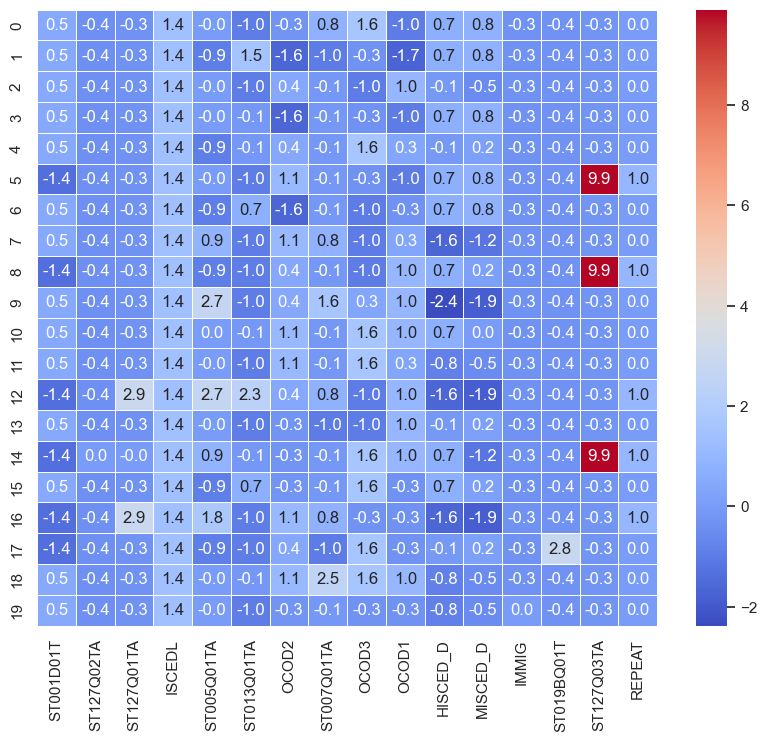

In [7]:
#把REPEAT列提取出来
output=df['REPEAT']
output = output.to_numpy()
df.drop('REPEAT', axis=1, inplace=True)
#选择特征
df=df[df_new]
#把字符串类型转换为int类型
le=sp.LabelEncoder()
str_col=['OCOD1','OCOD2','OCOD3']
for i in str_col:
    df[i]=le.fit_transform(df[i])
#具体处理df_new中每一个特征
for i in ['ST001D01T','ISCEDL','ST005Q01TA','ST007Q01TA','HISCED_D','MISCED_D']:
    df.loc[df[i] > 90, i] = np.nan
for i in ['ST127Q01TA','ST127Q02TA','ST127Q03TA','IMMIG']:
    df.loc[df[i] > 3, i] = np.nan
for i in ['OCOD2','OCOD1','OCOD3']:
    df.loc[df[i] > 9703, i] = np.nan
#分箱去噪
num_columns = df.shape[1]
bins=int(num_columns/3)
for i in range(num_columns):
    df[df.columns[i]] = pd.cut(df[df.columns[i]], bins).apply(lambda x: x.mid).astype(float)
#NAN填充
df.fillna(df.mean(), inplace=True)
#规范化
df=df.apply(zscore)
#重新加入目标列
df['REPEAT']=output
#绘制预处理结果
sns.heatmap(df.head(20), annot=True, fmt=".1f",linewidth=.5,cmap='coolwarm')
plt.show()

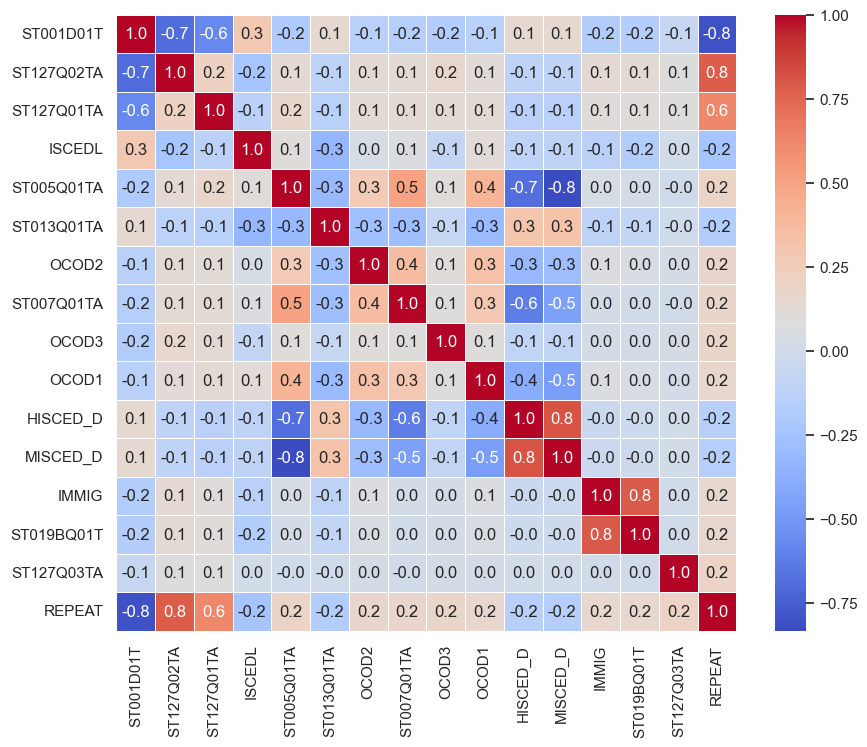

In [8]:
#绘制协方差矩阵
map_corr = df.corr(method='pearson')
sns.heatmap(map_corr, annot=True, fmt=".1f",linewidth=.5,cmap='coolwarm')
plt.show()

In [9]:
#计算自构造特征值
df_self=df[['REPEAT']]
df_self['SELF']=df['ST001D01T']+df['ISCEDL']-df['OCOD3']
df_self['EVERE']=df['ST127Q01TA']+df['ST127Q02TA']+df['ST127Q03TA']
df_self['PARED']=5-df['ST005Q01TA']+5-df['ST007Q01TA']+df['HISCED_D']+df['MISCED_D']
df_self['ENVIR']=-df['ST013Q01TA']+df['OCOD2']+df['OCOD1']+df['IMMIG']+df['ST019BQ01T']
df_self['EVERE0-1']=df_self['EVERE'].apply(lambda x: 1 if x > 0 else 0)

count    42102.000000
mean         0.206617
std          0.404883
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: REPEAT, dtype: float64


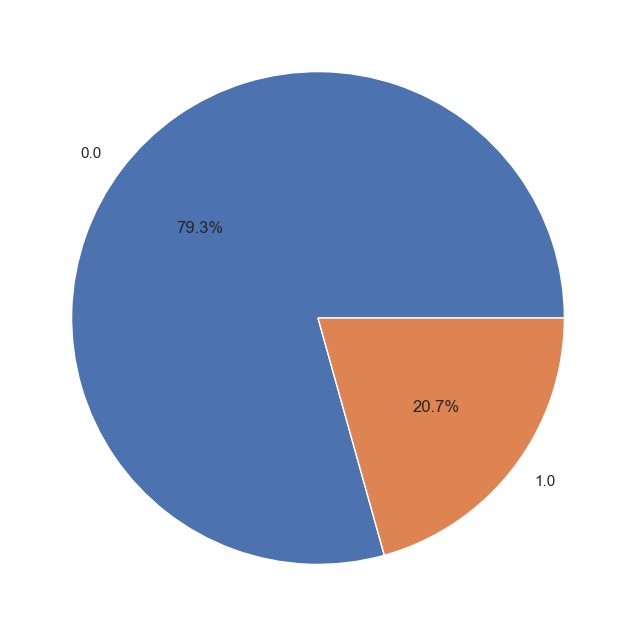

In [10]:
#REPEAT列数理统计
print(df_self['REPEAT'].describe())
counts = df['REPEAT'].value_counts()
plt.pie(counts.values, labels=counts.index,autopct='%1.1f%%')
plt.show()

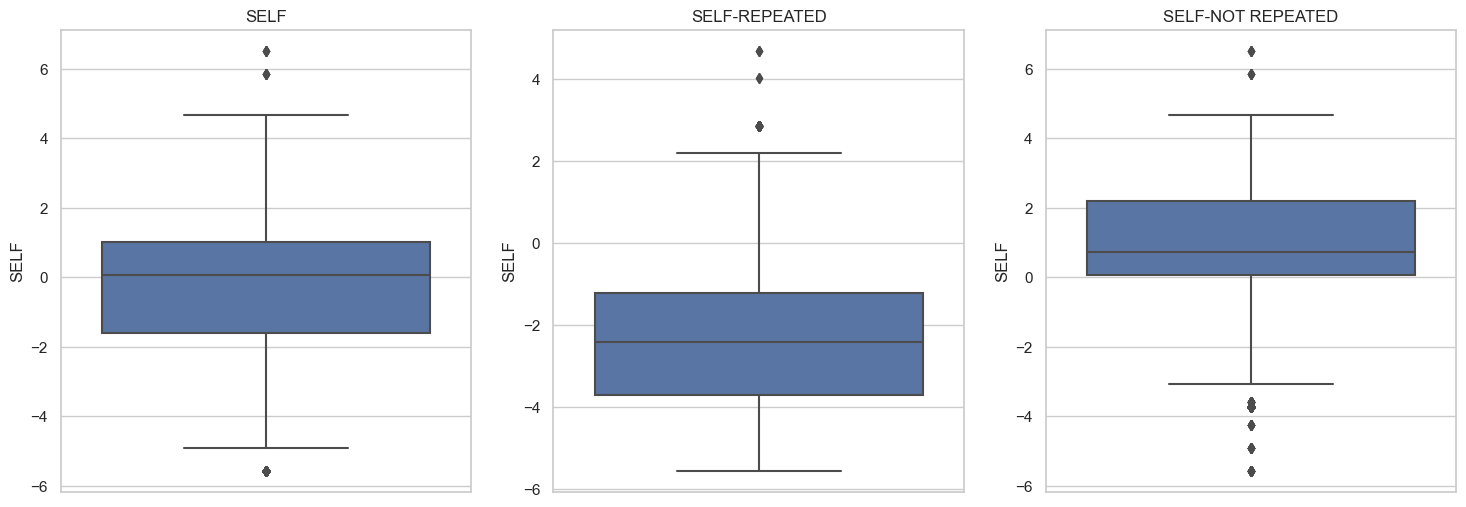

In [11]:
#SELF与REPEAT的相关性
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.boxplot(y='SELF', data=df_self)
plt.title('SELF')
plt.subplot(1,3,2)
sns.boxplot(y='SELF', data=df_self[df_self.REPEAT==1])
plt.title('SELF-REPEATED')
plt.subplot(1,3,3)
sns.boxplot(y='SELF', data=df_self[df_self.REPEAT==0])
plt.title('SELF-NOT REPEATED')
plt.show()

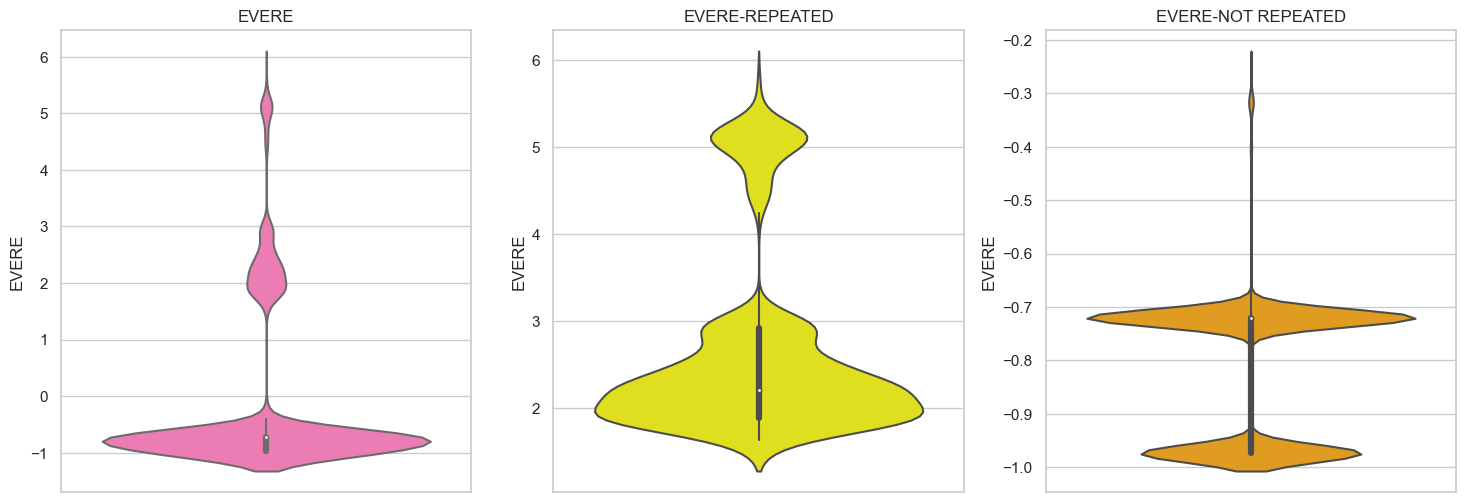

In [12]:
#EVERE与REPEAT的相关性
#3sigma处理异常值
df_self1=df_self[np.abs(df_self['EVERE']-df_self['EVERE'].mean())<=(3*df_self['EVERE'].std())]

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.violinplot(y='EVERE', data=df_self1,color='hotpink')
plt.title('EVERE')
plt.subplot(1,3,2)
sns.violinplot(y='EVERE', data=df_self1[df_self1.REPEAT==1],color='yellow')
plt.title('EVERE-REPEATED')
plt.subplot(1,3,3)
sns.violinplot(y='EVERE', data=df_self1[df_self1.REPEAT==0],color='orange')
plt.title('EVERE-NOT REPEATED')
plt.show()

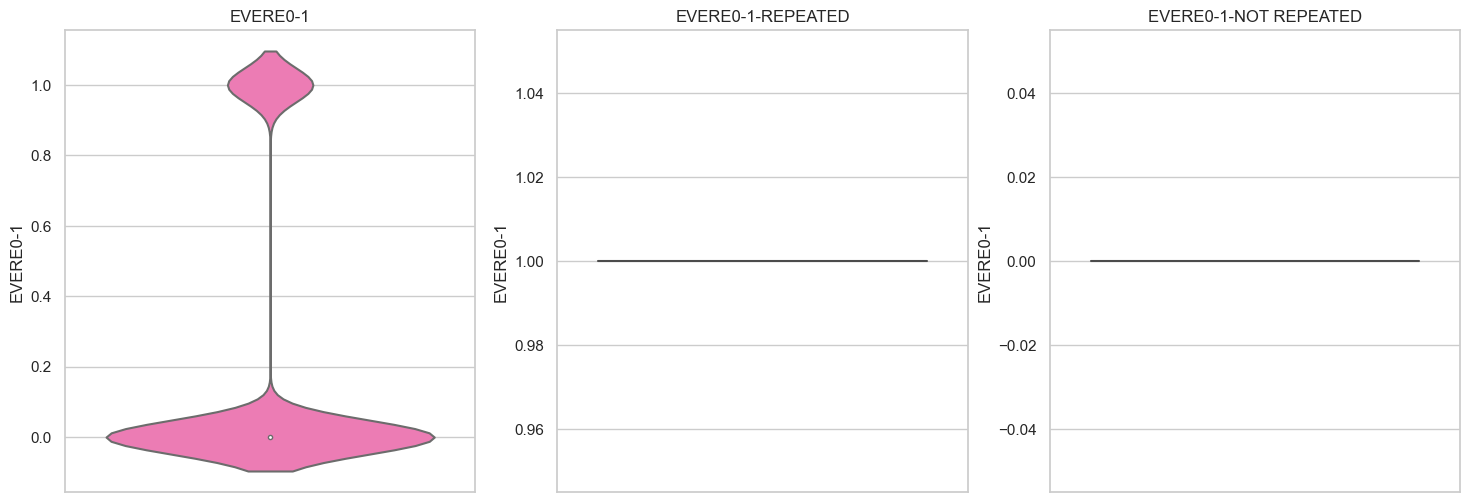

In [13]:
#EVERE0-1与REPEAT的相关性
df_self1=df_self[np.abs(df_self['EVERE0-1']-df_self['EVERE0-1'].mean())<=(3*df_self['EVERE0-1'].std())]

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.violinplot(y='EVERE0-1', data=df_self1,color='hotpink')
plt.title('EVERE0-1')
plt.subplot(1,3,2)
sns.violinplot(y='EVERE0-1', data=df_self1[df_self1.REPEAT==1],color='yellow')
plt.title('EVERE0-1-REPEATED')
plt.subplot(1,3,3)
sns.violinplot(y='EVERE0-1', data=df_self1[df_self1.REPEAT==0],color='orange')
plt.title('EVERE0-1-NOT REPEATED')
plt.show()

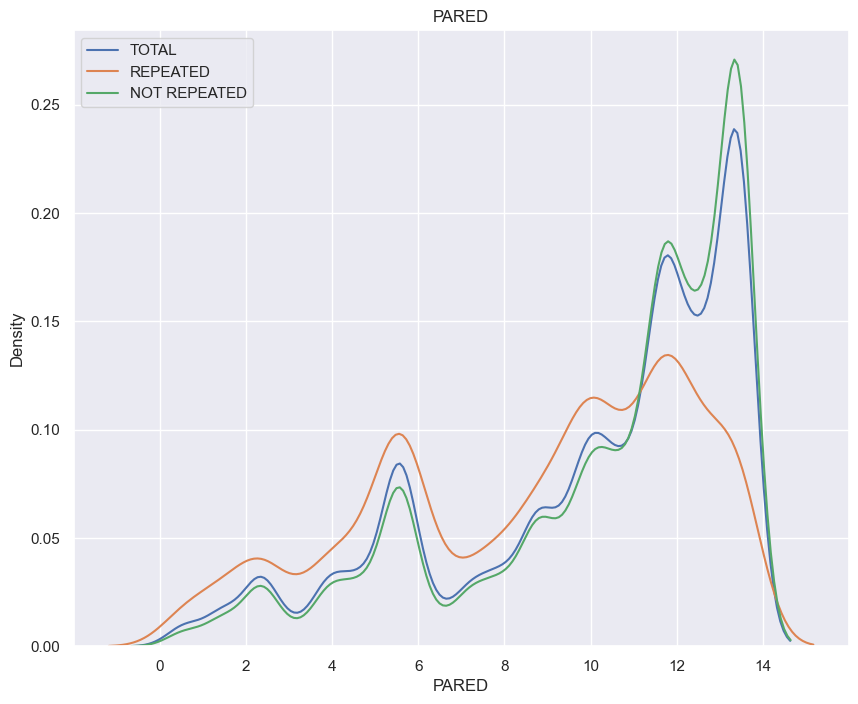

In [14]:
#PARED与REPEAT的相关性
plt.figure()
sns.set_style('darkgrid')
sns.kdeplot(data=df_self,x='PARED',label='TOTAL')
sns.kdeplot(data=df_self[df_self.REPEAT==1],x='PARED',label='REPEATED')
sns.kdeplot(data=df_self[df_self.REPEAT==0],x='PARED',label='NOT REPEATED')
plt.legend()
plt.title('PARED')
plt.show()

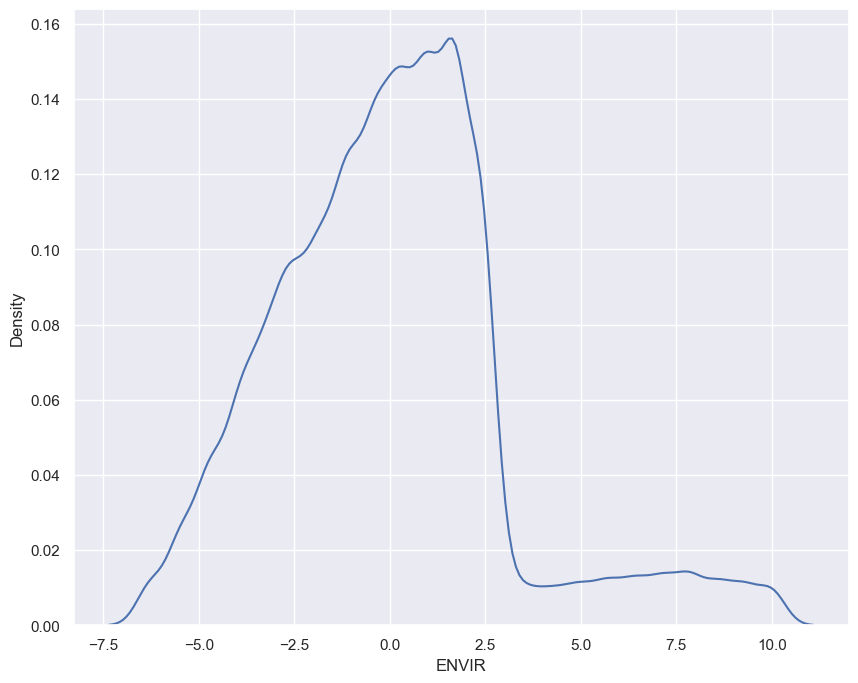

In [15]:
#ENVIR与REPEAT的相关性
#ENVIR总体分布
plt.figure()
sns.set_style('darkgrid')
sns.kdeplot(data=df_self,x='ENVIR',label='TOTAL')
plt.show()

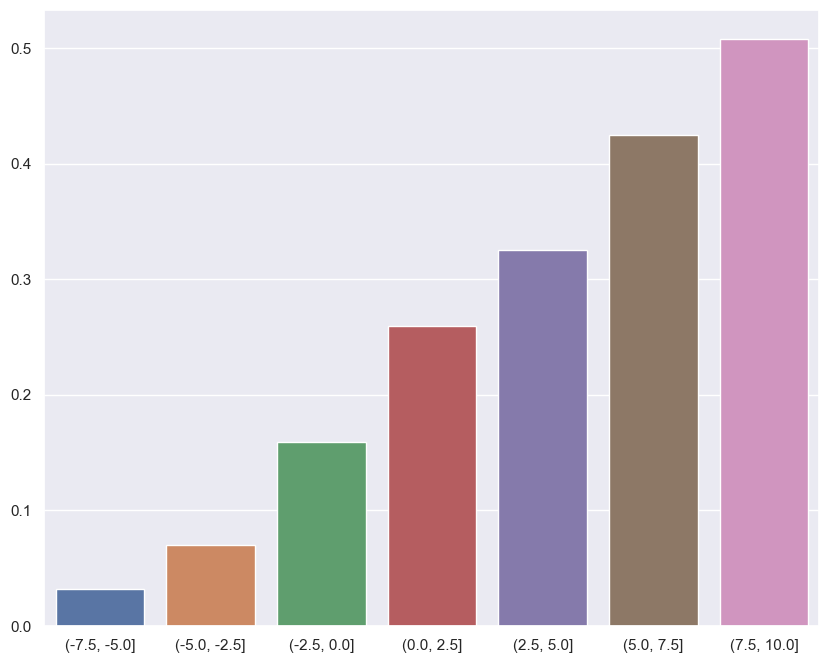

In [16]:
#离散化
bins = [i/2 for i in range(-15,21,5)]
df_self['ENVIR_NEW']=pd.cut(df_self.ENVIR,bins=bins)
REPEAT_rate=df_self[df_self.REPEAT==1]['ENVIR_NEW'].value_counts().sort_index()/df_self.ENVIR_NEW.value_counts().sort_index()
#ENVIR与REPEAT的相关性
plt.figure()
plt.subplot()
sns.barplot(x=REPEAT_rate.index,y=REPEAT_rate.values)
plt.show()